In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [41]:
from matplotlib.colors import ListedColormap

In [42]:
#df = pd.read_excel('pack_benchmark_spec_v1.038.xlsx','Benchmarks',header=[0,1])
df = pd.read_excel('pack_benchmark_spec_v1.042.xlsm','Benchmarks',header=[0,1],skiprows=1,nrows=1055)

We will use _features_ for design (i.e. independent) variables and _metrics_ for the resulting, measurable (i.e. dependent variables) that describe the battery packs. \
This is one example of a set of features:

In [43]:
feature_set_0 = [('Cell',ft) for ft in ['Chemistry','Format','Capacity Ah','Nom V','mass kg']] + [('Configuration',ft) for ft in ['s','p']]

First of all, let's visualise the relationship between pack volumetric / gravimetric efficiency, SoC window, and voltage vs. cell chemistry, format, and pack configuration. 

In [44]:
metric_set_0 = [('SoC Window','Unnamed: 7_level_1'),
                ('Nominal Voltage','V'),
                ('Gravimetric Energy Density','Wh/kg'),
                ('Volumetric Energy Density','Wh/litre'),
                ('Gravimetric Power Density','W10s/kg'),
                ('Cell to Pack Ratio','%')
                ]

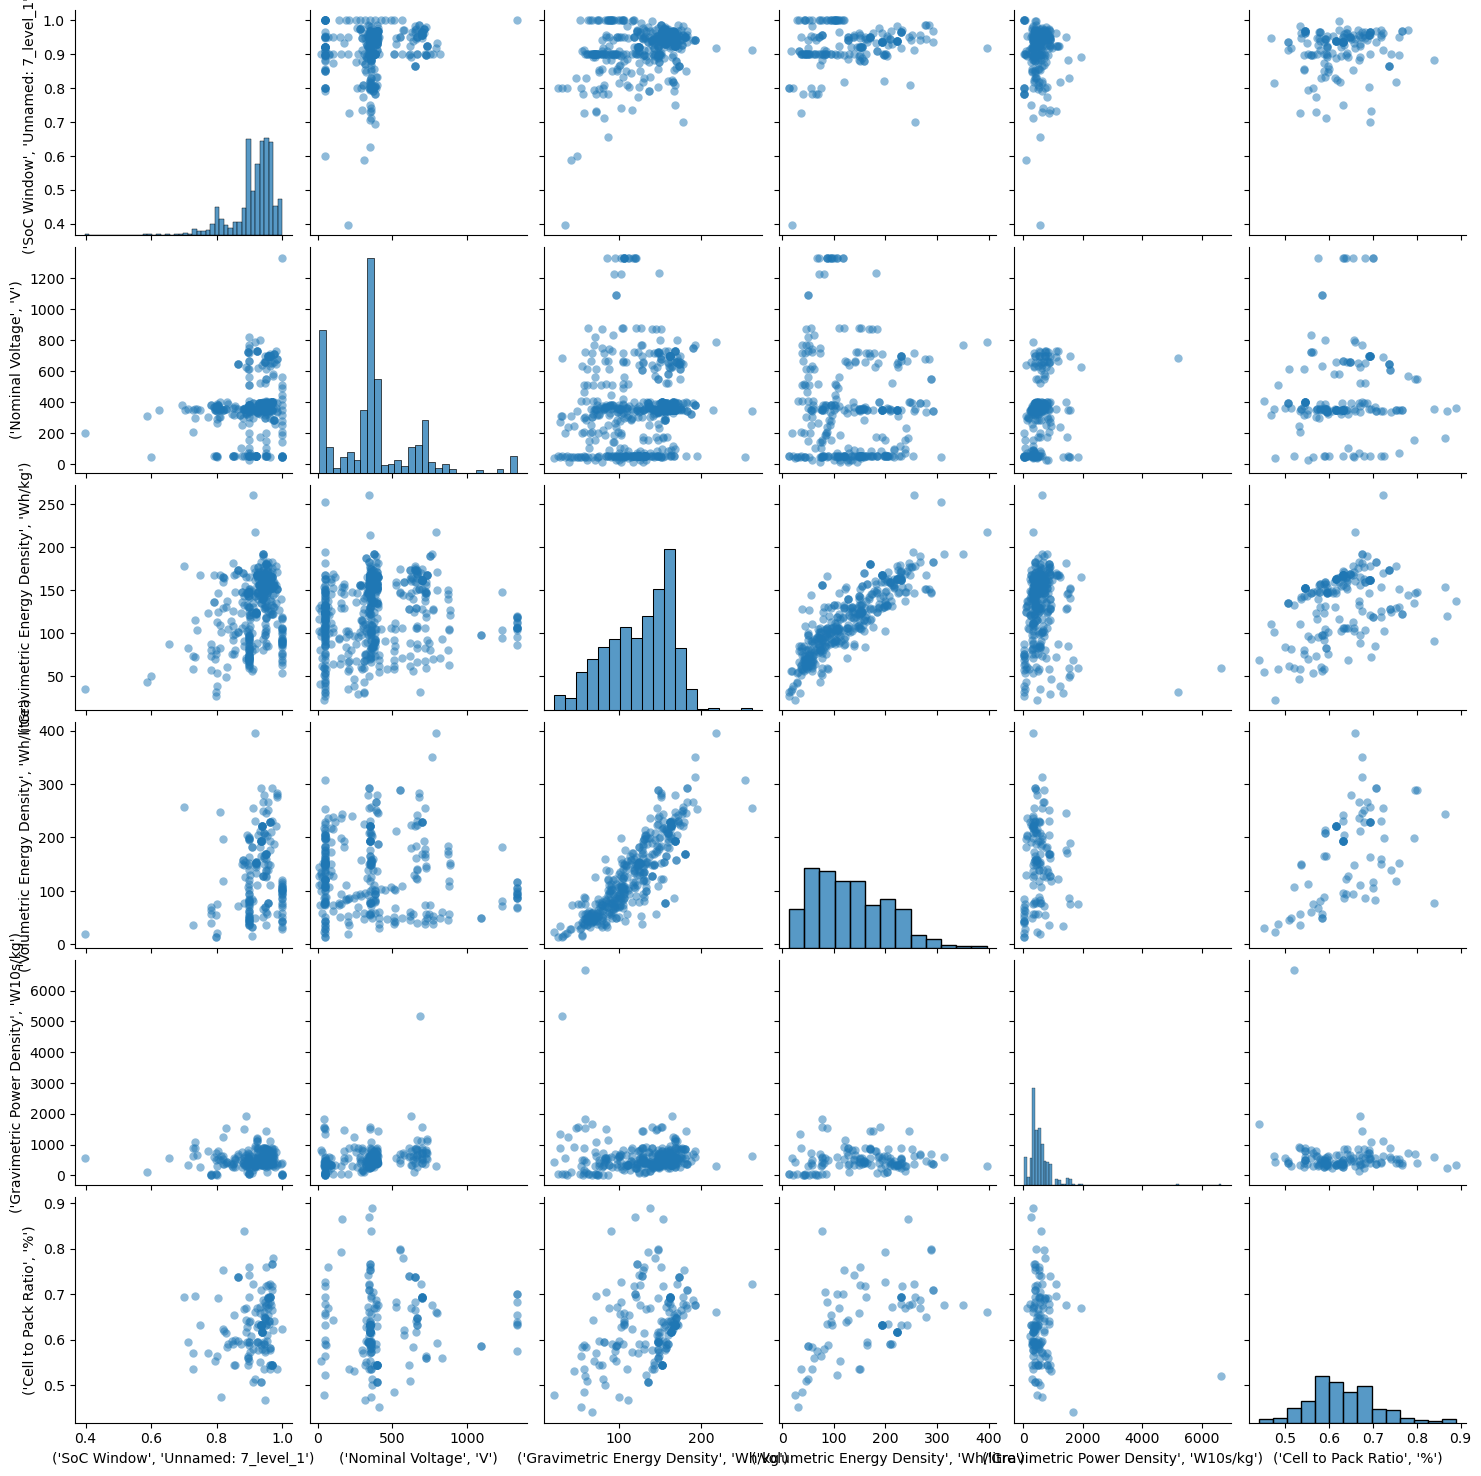

In [45]:
sns.pairplot(df.loc[:,metric_set_0],diag_kind='hist',plot_kws={'alpha':0.5,'linewidth':0.0})

Volumetric energy density has a strong correlation with gravimetric energy density and cell to pack ratio, and it's inclusion halves the number of datapoints with complete data for all metrics, so we will drop it from the metrics being analysed. 

In [46]:
metric_set_1 = [('SoC Window','Unnamed: 7_level_1'),
                ('Nominal Voltage','V'),
                ('Gravimetric Energy Density','Wh/kg'),
                #('Volumetric Energy Density','Wh/litre'),
                ('Gravimetric Power Density','W10s/kg'),
                ('Cell to Pack Ratio','%')
                ]

feature_set_1 = [('Cooling','Type')] + [('Cell',ft) for ft in ['Chemistry','Format','Capacity Ah']] + [('Configuration',ft) for ft in ['s','p']]

In [47]:
df_subset_1 = df.loc[:,metric_set_1].dropna(axis=0) 
df_subset_1 = pd.concat((df.loc[df_subset_1.index,('First produced','Unnamed: 4_level_1')],df_subset_1,df.loc[df_subset_1.index,feature_set_1]),axis=1)
print('{} total data entries'.format(df_subset_1.shape[0]))

97 total data entries


The idea here is to cluster battery packs based on metrics resulting from design choices, then assess trends in the resulting clusters vs their design features. We will use [t-SNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) as the data reduction method, and project into 2D because that can be visualised. 

In [154]:
model = Pipeline([('scaler',StandardScaler()),
                  ('dim_reducer',TSNE(perplexity=15.0,early_exaggeration=50.0))
                  ])

In [155]:
X_embedded = model.fit_transform(df_subset_1.loc[:,metric_set_1])

We will now identify clusters algorithmically. Arguably, human identification works better here. 

In [164]:
n_clusters = 6
cmodel = GaussianMixture(n_components=n_clusters,random_state=1800,n_init=100,init_params='k-means++')
y_cluster = cmodel.fit_predict(X_embedded)

In [165]:
coords_0,coords_1 = np.meshgrid(np.linspace(1.1*X_embedded[:,0].min(),
                        1.1*X_embedded[:,0].max(),200),
            np.linspace(1.1*X_embedded[:,1].min(),
                        1.1*X_embedded[:,1].max(),200)) 

In [166]:
lscape = cmodel.predict_proba(np.c_[coords_0.reshape(-1),coords_1.reshape(-1)])
contours = {}
for i in range(n_clusters):
    lscape_max_not_i = np.max(np.c_[lscape[:,:i],lscape[:,i+1:]],axis=1)
    contours[i] = (lscape[:,i]-lscape_max_not_i).reshape(200,200)

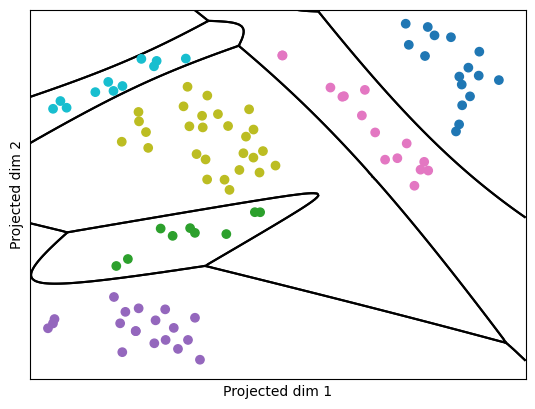

In [167]:
for i in range(n_clusters):
    plt.contour(coords_0,coords_1,contours[i],[0.0],colors='k',zorder=10)
plt.scatter(*X_embedded.T,c=y_cluster,cmap='tab10',zorder=100)
plt.xticks([])
plt.yticks([])
plt.xlabel('Projected dim 1')
plt.ylabel('Projected dim 2') ;

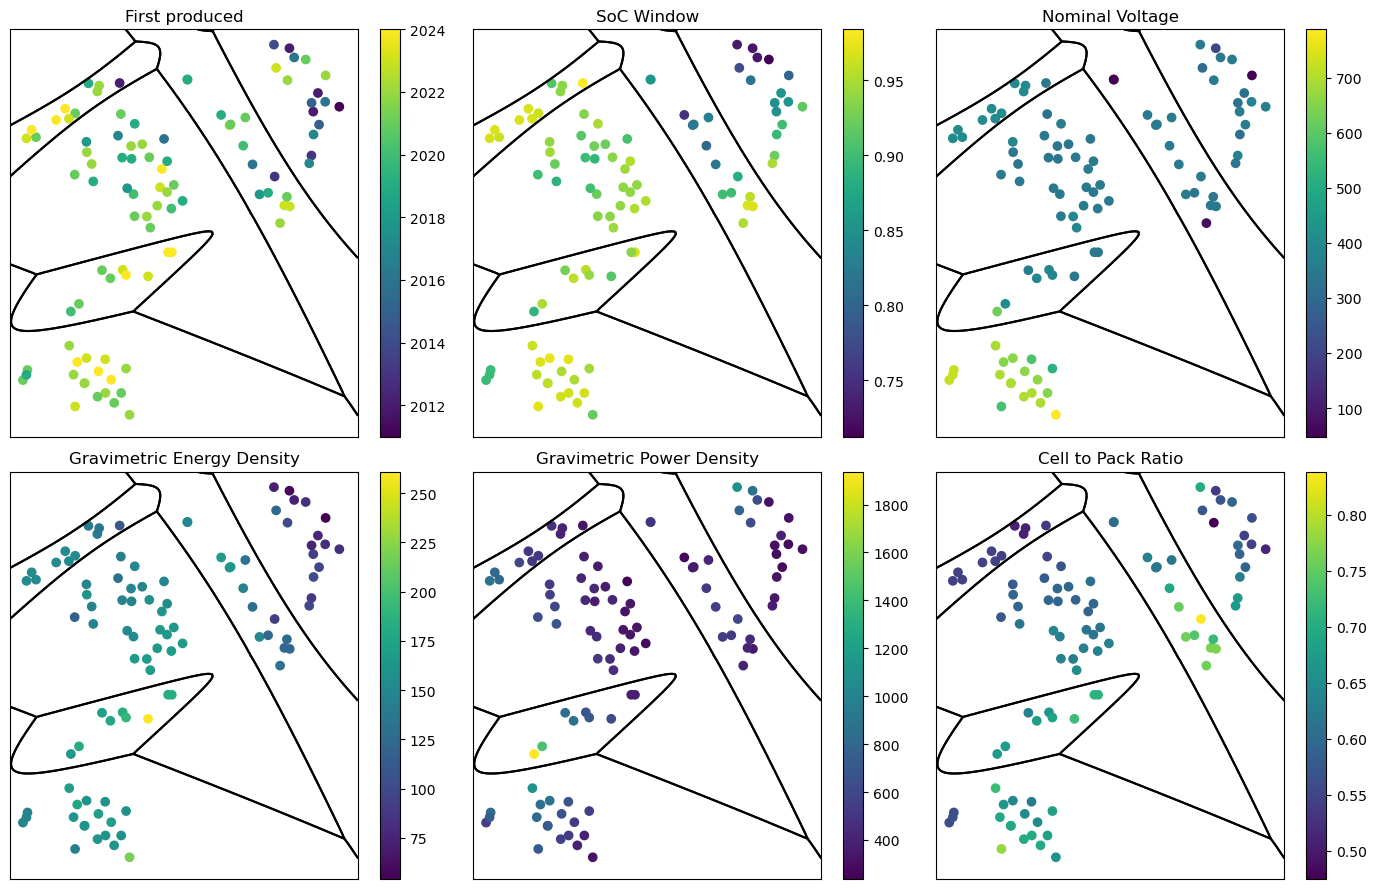

In [168]:
fig,axs=plt.subplots(nrows=2,ncols=3,figsize=(14,9))
for i,metric in enumerate(df_subset_1.columns[:6].values):
    ax = axs[i//3,i%3]
    scttr = ax.scatter(*X_embedded.T,
            c=df_subset_1.loc[:,metric],
            label=df_subset_1.loc[:,metric]
            #c=df_subset_1.loc[:,('Cell','Chemistry')].astype('category').cat.codes,cmap='tab20'
            )
    fig.colorbar(scttr,ax=ax)
    ax.set_title(metric[0])
    for j in range(n_clusters):
        ax.contour(coords_0,coords_1,contours[j],[0.0],colors='k',zorder=10)
        
    ax.set_xticks([])
    ax.set_yticks([])        

fig.tight_layout()

We will now plot the clusters with colours based on cell chemistry (using a custom colormap), and also cell format. 

In [169]:
df_subset_1.loc[:,('Cell','Chemistry')].astype('category').cat.categories

Index(['LFP', 'LMO', 'LTO', 'NCA', 'NCMA', 'NMC', 'NMC111', 'NMC523', 'NMC622',
       'NMC712', 'NMC811'],
      dtype='object')

In [170]:
cell_chem_cmap = ListedColormap(['lightgray','gold','cyan','darkviolet','limegreen','forestgreen','coral','pink','indianred','crimson','firebrick','maroon'],N=12)
cell_chem_cmap.set_bad('lightgray')

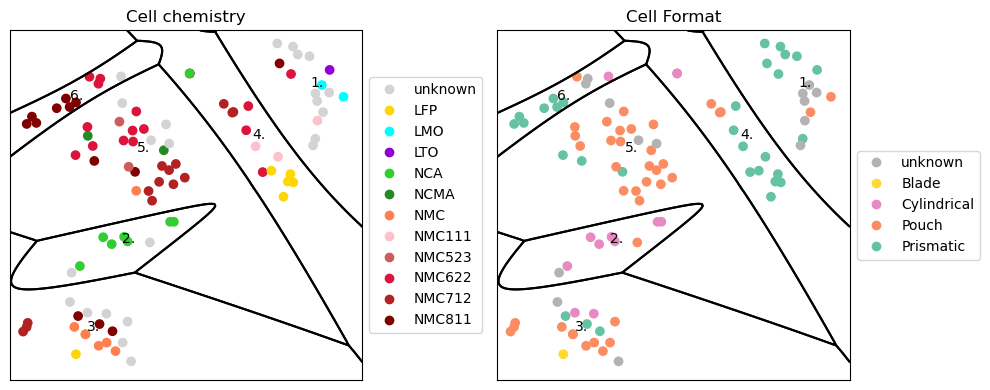

In [171]:
fig,axs=plt.subplots(ncols=2,figsize=(10,4))
# 1st plot
ax = axs[0]
scttr = ax.scatter(*X_embedded.T,
        c=df_subset_1.loc[:,('Cell','Chemistry')].astype('category').cat.codes,cmap=cell_chem_cmap,
        )
handles,labels=scttr.legend_elements()
for j in range(n_clusters):
    # plot decision boundaries
    ax.contour(coords_0,coords_1,contours[j],[0.0],colors='k',zorder=10)
    # label clusters
    ax.text(*cmodel.means_[j],'{}.'.format(j+1))
ax.legend(handles,np.concat((['unknown'],df_subset_1.loc[:,('Cell','Chemistry')].astype('category').cat.categories.values)),
           loc='center left', bbox_to_anchor=(1.0,0.5))
ax.set_title('Cell chemistry')
ax.set_xticks([])
ax.set_yticks([]) 
# 2nd plot
ax = axs[1]
scttr = ax.scatter(*X_embedded.T,
        c=df_subset_1.loc[:,('Cell','Format')].astype('category').cat.codes,cmap='Set2_r',
        )
handles,labels=scttr.legend_elements()
for j in range(n_clusters):
    # plot decision boundaries
    ax.contour(coords_0,coords_1,contours[j],[0.0],colors='k',zorder=10)
    # label clusters
    ax.text(*cmodel.means_[j],'{}.'.format(j+1))
ax.legend(handles,np.concat((['unknown'],df_subset_1.loc[:,('Cell','Format')].astype('category').cat.categories.values)),
           loc='center left', bbox_to_anchor=(1.0,0.5))
ax.set_title('Cell Format')
ax.set_xticks([])
ax.set_yticks([]) 

fig.tight_layout()